# CUWALID MODEL TRAINING

## Simulating Hydrology from a Seasonal Forecast

#### Contents

The following course cover the following content:

* Convert climate seasonal forecasting into model forcing datasets
* **Translate climate forecasting into hydrological forecasting**


### 3. Translate climate forecasting into hydrological forecasting

1. Preparing tercile forecasting
* Runing multiple simulaiton
* Understanding seasonal hydrological forecasting

**WARNING!**. Before you start the analyis, please make sure that you directories have the following structure. All required files are already located on the server.

In [1]:
print("Local_directory\n|__training\n      |___forecast\n      |      |__regional\n      |      |     |__datasets\n      |      |     |    |__csv\n      |      |     |    |__shp\n      |      |     |__model\n      |      |     |    |__inputs\n      |      |     |__outputs\n      |      |     |__postpp\n      |      |          |__csv\n      |      |          |__netcdf\n      |      |          |__raster\n      |      |          |__fig\n      |	     |__basin\n      |___historical\n             |__regional\n             |     |__datasets\n             |     |__model\n             |     |__outputs\n             |     |__postpp\n       	     |__basin\n")

Local_directory
|__training
      |___forecast
      |      |__regional
      |      |     |__datasets
      |      |     |    |__csv
      |      |     |    |__shp
      |      |     |__model
      |      |     |    |__inputs
      |      |     |__outputs
      |      |     |__postpp
      |      |          |__csv
      |      |          |__netcdf
      |      |          |__raster
      |      |          |__fig
      |	     |__basin
      |___historical
             |__regional
             |     |__datasets
             |     |__model
             |     |__outputs
             |     |__postpp
       	     |__basin



### 3.1 Forcast: Preparation

The first stage of the forecasting analysis consist of preprocesing the historical simulations ("hindcast"). It includes preprocessing, temporal aggregation, and estimation of historical thresholds for all analysed variables.

All model simulations for both historical and forecasting outputs are located in the corresponding directories.

In order to quickly access all model files during the entire historical analysis, a "config_hindcast.py" file has been created. This file contain all paths required to store variables as well as additional parameters used in the analysis. A similar file was created for the forecasting, "config_forecasting.py", which will be used for all files and directories during the forecasting analysis.

Additional tools for post-processing and ploting model and forecasting outputs is also provided. This component also has a config file, "config_plot_cuwalid.py", however, not all component are connected in order to allow this component to run separately.

Some scripts make take hours to run, so make sure you allocate enough time to run the process. Also, scripts are namem using numerical labels, this indicates the files need to be run sequentially. Files with the same number can be run at the same time.

Please, make sure that the following list of files are available on your system.

### Prepare Historical simulation

Preprocessing historical values

Understanding and modifying config hindcast file

In [51]:
#config_hindcast.py

* In the config_hindcast.py file the variable postpp_path should be as follows:

postpp_path = "/home/<username>/training/historical/regional/postpp/"

Concatenate *.csv files from yearly simulation files

In [52]:
#%00_cuwalid_HAD_get_csv_TS_files_from_multi_CSV.py

Calculate total water storage anomalies (TWSA) from storage (TWSC)

In [53]:
#%run 01a_cuwalid_HAD_get_TWSA_from_mult_files.py

Calculate Water Requirement Satisfaction Index (WRSI) and Calculate total Actual evapotranspirationt (aet) by adding actual evapotranspiration (aet) and evaporation from capillary rise (egw)

In [54]:
#%run 01b_cuwalid_HAD_get_additional_variables_multi_netcdf.py

Calculate average values from historical simulations. Depending on the number of variables that has been selected, this script may take a couple of hours to run.

In [55]:
#%02d_cuwalid_HAD_get_average_multi_netcdf.py

Calculate thresholds from historical simulations, terciales approach. This is only required once since these thresholds are constant over time. These threshold should be updated when the historical period increases(i.e. once a year).

Calculate percentiles 1/3 and 2/3

In [56]:
#%02a_cuwalid_HAD_get_percentiles_multi_files.py

### Forecast analysis

Understanding and modifying the config forecasting file

In [57]:
#config_forecasting.py

* In the config_forecasting.py file the variable model_name should be as follows:

model_name= 'MAM_2022_realization_test'

* In the config_forecasting.py file the variable postpp_path  should be as follows:

postpp_path = "/home/<username>/training/forecast/regional/postpp/"

* In the config_forecasting.py file the variable threshold_path should be as follows:

threshold_path = "/home/<username>/training/historical/regional/postpp/netcdf/HAD_IMERGba_sim0_MAM_extremes_quantiles.nc"


Post-processing hydrological variables of the ensamble simulation (e.g. calculate TWSA and WRSI)

In [ ]:
#08_cuwalid_HAD_get_updated_TWSA_ensamble.py

Generate ensamble of model simulations for each variable from the forecasting

In [58]:
#09_cuwalid_HAD_get_ensamble_forecasting.py

Caclulate tercile probabilistic forecasting from the ensamble simulations 

In [59]:
#10a_cuwalid_HAD_get_probabilistic_tercile_forecast_ensamble.py

Calculate the deterministic forecast from the ensamble of simulations.

In [60]:
#%10b_cuwalid_HAD_get_deterministic_forecast_ensamble.py

### 3.2 Understanding seasonal hydrological forecast

In [1]:
# Import general libraries
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Import libraries from local repository
import sys
#sys.path.append('C:/Users/Edisson/Documents/GitHub/DRYPv2.0.1')
sys.path.append("/home/cuwalid/CUWALID/DRYP/")
import tools.DRYP_pptools as pptools
import xarray as xr

### Working with historical total averages

**WARNING**! This section needs to donwload files from the server, so before move to the following section, download all csv files from the forecastin outputs

* Assesing the temporal variability of water balance components

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import rasterio

In [3]:
def aggregate_slice_csv(fname, agg_step='M', mean=False, date_start='2000-01-01', date_end='2023-01-01', timefield='Date'):
	df = read_csv(fname, timefield, date_start, date_end)
	return aggregate_dataframe(df, agg_step, mean).reset_index()
	#return df

def get_seasson_csv(fname, months, mean=False, reset_index=True, date_start='2000-01-01', date_end='2023-01-01', timefield='Date', aggregate=True):
    df = read_csv(fname, timefield, date_start, date_end)
    #print(df)
    df = aggregate_dataframe(df, 'M', mean)
    # Use boolean indexing to select the specified months
    df = df[df.index.month.isin(months)]
    if aggregate is True:
        df = aggregate_dataframe(df, 'Y', mean)
    if reset_index is True:
        df = df.reset_index()
    return df

def read_csv(fname, timefield, date_start, date_end):
	df = pd.read_csv(fname)
	df[timefield] = pd.to_datetime(df[timefield])
	df = df[df[timefield].between(date_start, date_end)]
	df.index = pd.DatetimeIndex(df[timefield])
	#print(df)# = df.drop([timefield])
	return df

def aggregate_dataframe(df, agg_step, mean):
	#print(df)
	if mean is True:
		df = df.resample(agg_step).mean(numeric_only=True)#.reset_index()
	else:
		df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()
	return df
    

In [4]:
def plot_anomalies_bar(time, var, threshold=0, bar_width = 300, ax=None):
    """Create a bar plot of anomalies"""
    # create plot
    if ax is None:
        fig, ax = plt.subplots()
    x_values = np.arange(len(time))+time[0].year
    mask_avobe = var < threshold
    mask_below = var >= threshold
    #ax.bar(x_values[mask_avobe], var[mask_avobe], width=bar_width, color='r')#, alpha=1.00)
    #ax.bar(x_values[mask_below], var[mask_below], width=bar_width, color='b')#, alpha=1.00)
    ax.bar(time[mask_avobe], var[mask_avobe], width=bar_width, color='r')#, alpha=1.00)
    ax.bar(time[mask_below], var[mask_below], width=bar_width, color='b')#, alpha=1.00)

def plot_anomalies_line(time, var, threshold=0, ax=None):
    """Create a bar plot of anomalies"""
    # create plot
    if ax is None:
        fig, ax = plt.subplots()
    ax.fill_between(time, var, threshold, where=(var > threshold), interpolate=True, color='blue')#, alpha=.25)
    ax.fill_between(time, var, threshold, where=(var <= threshold), interpolate=True, color='red')#,  alpha=.25)

* Create yearly anomalies of water balance components

Specify the name of the model results files for ttime series 

In [5]:
#fname_csv = basin_path + "output/Tana_IMb_sim_avg.csv"
#fname_csv = "D:/HAD/postpp/csv/HAD_IMERGba_sim0_avg.csv"
fname_csv = "/home/cuwalid/training/historical/regional/outputs/HAD_IMERGba_sim0_avg.csv"

Calculate yearly and seasonal anomalies

In [29]:
# Calculate yearly anomalies
# read dataset, slice and temporaly aggregate
dfavg = aggregate_slice_csv(fname_csv, agg_step='Y')
#calculate mean 
mean_avg = dfavg.mean()

/tmp/ipykernel_2039448/249471917.py:31: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()


Text(0.5, 1.0, 'precipitation anomalies')

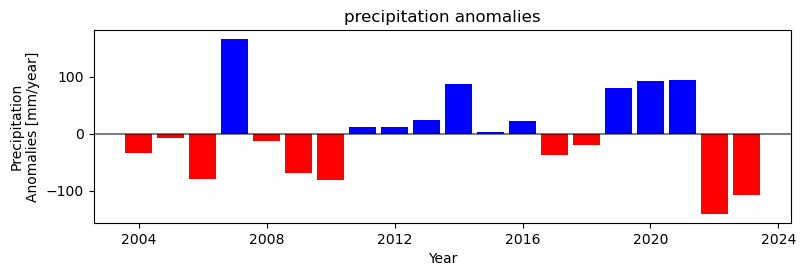

In [30]:
ifield = 'pre_0'
fig, ax = plt.subplots()#1, 1, sharex=True, sharey=True)
fig.set_size_inches(9, 2.5)
plot_anomalies_bar(dfavg['Date'], dfavg[ifield].values-mean_avg[ifield], ax=ax)
plt.xlabel('Year')
plt.axhline(0, color='k', alpha=0.5)
plt.ylabel('Precipitation\nAnomalies [mm/year]')
plt.title("precipitation anomalies")

* Create seasonal anomalies for March-May (MAM)

In [31]:
# calculate seasonal anomalies
# select seasons
data_MAM = get_seasson_csv(fname_csv, [3, 4, 5]).reset_index()
# get mean values from season
mean_MAM = data_MAM.mean()
# get anomales of historical values
#anomaly_MAM = data_MAM - mean_MAM

/tmp/ipykernel_2039448/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()
/tmp/ipykernel_2039448/249471917.py:31: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()


In [32]:
#data_MAM.head(3)

Plot precipitation seasonal anomalies

Text(0.5, 1.0, 'MAM precipitation anomalies')

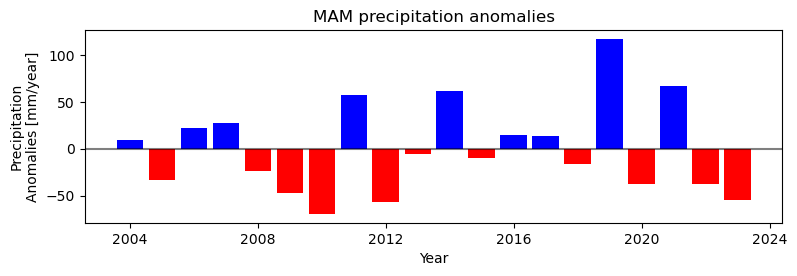

In [33]:
ifield = 'pre_0'
fig, ax = plt.subplots()#1, 1, sharex=True, sharey=True)
fig.set_size_inches(9, 2.5)
#plot_anomalies_bar(dfavg['Date'], dfavg[ifield].values-mean_avg[ifield], ax=ax)
plot_anomalies_bar(data_MAM['Date'], data_MAM[ifield].values-mean_MAM[ifield], ax=ax)
plt.xlabel('Year')
plt.axhline(0, color='k', alpha=0.5)
plt.ylabel('Precipitation\nAnomalies [mm/year]')
plt.title("MAM precipitation anomalies")

Plot actual evapotranspiration historical anomalies

Text(0, 0.5, 'Actual Evapotranspiration\n[mm/year]')

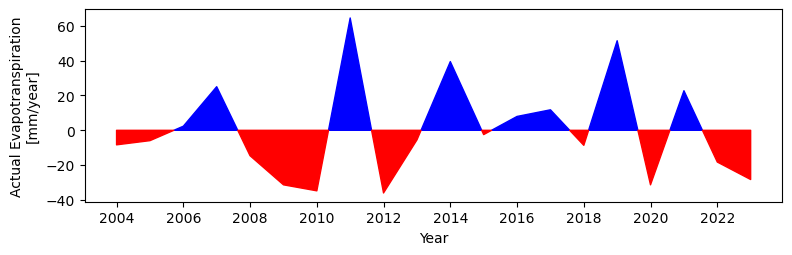

In [26]:
ifield = 'aet_0'
fig, ax = plt.subplots()#1, 1, sharex=True, sharey=True)
fig.set_size_inches(9, 2.5)
plot_anomalies_line(data_MAM['Date'], data_MAM[ifield].values-mean_MAM[ifield], ax=ax)
#plot_anomalies_line(dfavg['Date'], dfavg[ifield].values-mean_avg[ifield], ax=ax)
plt.xlabel('Year')
plt.ylabel('Actual Evapotranspiration\n[mm/year]')

**TASK**: Plot anomalies for soil moisture and groundwater recharge

Plot soil moisture histrical anomalies

Text(0, 0.5, 'Actual Evapotranspiration\n[mm/year]')

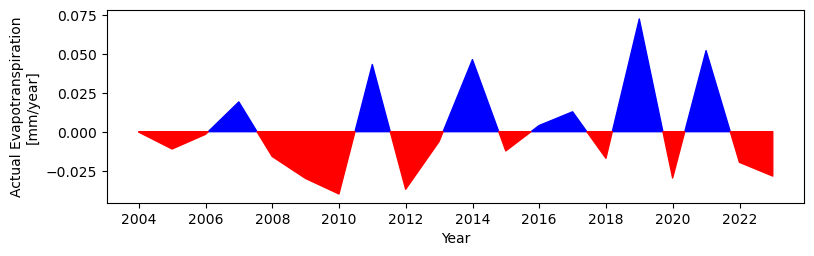

In [34]:
ifield = 'tht_0'
fig, ax = plt.subplots()#1, 1, sharex=True, sharey=True)
fig.set_size_inches(9, 2.5)
plot_anomalies_line(data_MAM['Date'], data_MAM[ifield].values-mean_MAM[ifield], ax=ax)
#plot_anomalies_line(dfavg['Date'], dfavg[ifield].values-mean_avg[ifield], ax=ax)
plt.xlabel('Year')
plt.ylabel('Actual Evapotranspiration\n[mm/year]')

Plot recharge historical anomalies

Text(0, 0.5, 'Actual Evapotranspiration\n[mm/year]')

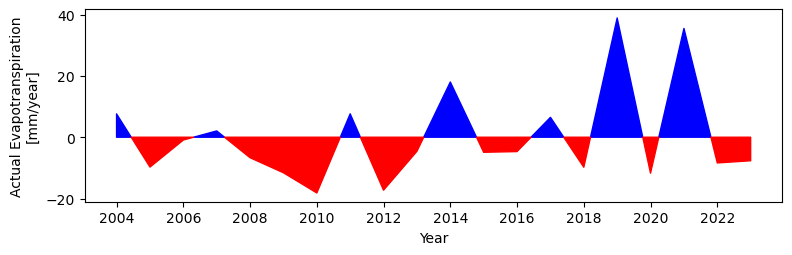

In [35]:
ifield = 'rch_0'
fig, ax = plt.subplots()#1, 1, sharex=True, sharey=True)
fig.set_size_inches(9, 2.5)
plot_anomalies_line(data_MAM['Date'], data_MAM[ifield].values-mean_MAM[ifield], ax=ax)
#plot_anomalies_line(dfavg['Date'], dfavg[ifield].values-mean_avg[ifield], ax=ax)
plt.xlabel('Year')
plt.ylabel('Actual Evapotranspiration\n[mm/year]')

#### Working with historical grided datasets

Plot mean of historical values

In [18]:
fname_nc = "/home/cuwalid/training/historical/regional/postpp/netcdf/HAD_IMERGba_sim0_MAM_mean.nc"

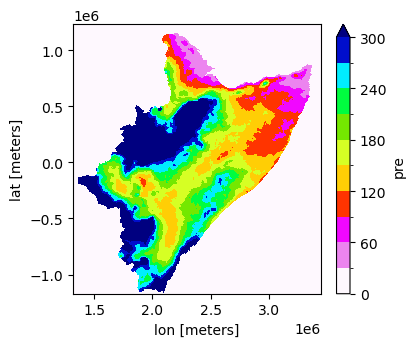

In [19]:
data = xr.open_dataset(fname_nc)['pre']
data.plot(x="lon", y="lat", robust=False, cmap='gist_ncar_r', levels=11, figsize=(4,3.5), vmin=0, vmax=300)

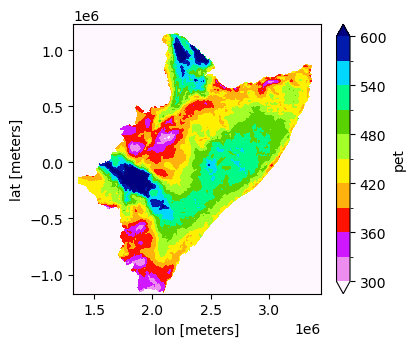

In [22]:
data = xr.open_dataset(fname_nc)['pet']
data.plot(x="lon", y="lat", robust=False, cmap='gist_ncar_r', levels=11, figsize=(4,3.5), vmin=300, vmax=600)

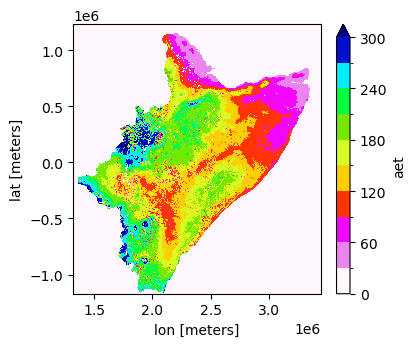

In [6]:
data = xr.open_dataset(fname_nc)['aet']
data.plot(x="lon", y="lat", robust=False, cmap='gist_ncar_r', levels=11, figsize=(4,3.5), vmin=0, vmax=300)

In [24]:
#data = xr.open_dataset(fname_nc)['rch']
#data.plot(x="lon", y="lat", robust=False, cmap='gist_ncar_r', levels=11, figsize=(4,3.5), vmin=0, vmax=300)

Plot terciles values from historical values

In [9]:
fname_nc = "/home/cuwalid/training/historical/regional/postpp/netcdf/HAD_IMERGba_sim0_MAM_quantiles.nc"

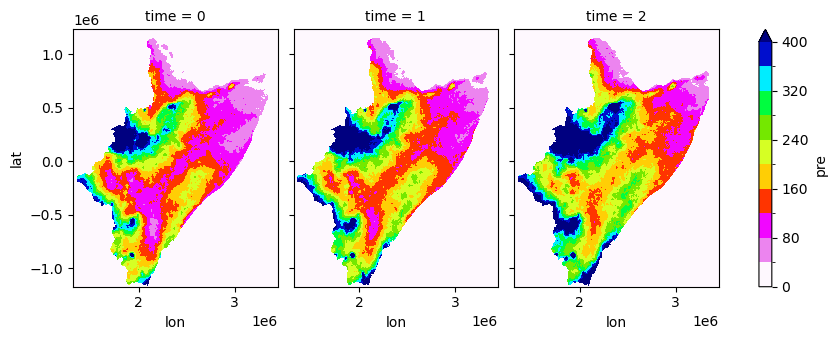

In [17]:
data = xr.open_dataset(fname_nc)['pre']
data.plot(x="lon", y="lat", col="time", robust=False, cmap='gist_ncar_r', levels=11, figsize=(9,3.5), vmin=0, vmax=400)

In [12]:
#data

<xarray.DataArray 'pre' (time: 3, lat: 2614, lon: 2313)> Size: 145MB
[18138546 values with dtype=float64]
Coordinates:
  * lat       (lat) float32 10kB -1.17e+06 -1.17e+06 ... 1.231e+06 1.232e+06
  * lon       (lon) float32 9kB 1.32e+06 1.32e+06 ... 3.444e+06 3.445e+06
    quantile  (time) float64 24B ...
Dimensions without coordinates: time

#### Visualizing anomalies

In [12]:
fname_nc = "/home/cuwalid/training/historical/regional/postpp/netcdf/HAD_IMERGba_sim0_MAM_pre_anomalies.nc"

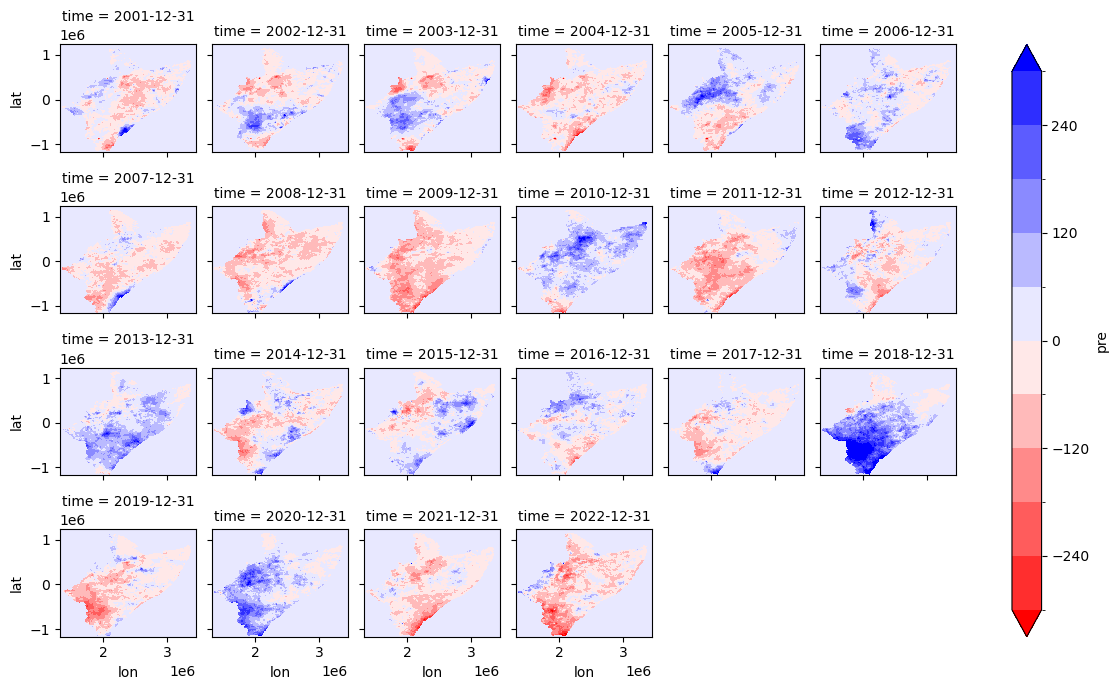

In [13]:
data = xr.open_dataset(fname_nc)['pre']
data.plot(x="lon", y="lat", col="time", robust=False, cmap='bwr_r', levels=11, figsize=(12, 7), vmin=-300, vmax=300, col_wrap=6)

In [6]:
fname_nc = "/home/cuwalid/training/historical/regional/postpp/netcdf/HAD_IMERGba_sim0_MAM_aet_anomalies.nc"

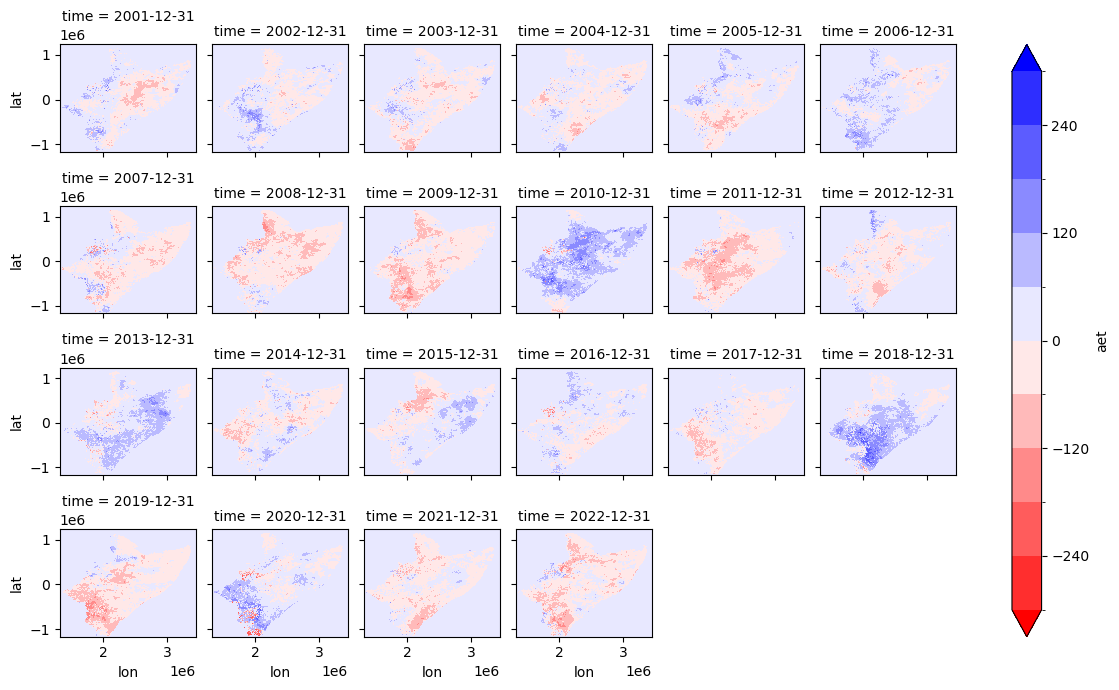

In [8]:
data = xr.open_dataset(fname_nc)['aet']
data.plot(x="lon", y="lat", col="time", robust=False, cmap='bwr_r', levels=11, figsize=(12, 7), vmin=-300, vmax=300, col_wrap=6)

In [9]:
fname_nc = "/home/cuwalid/training/historical/regional/postpp/netcdf/HAD_IMERGba_sim0_MAM_tht_anomalies.nc"

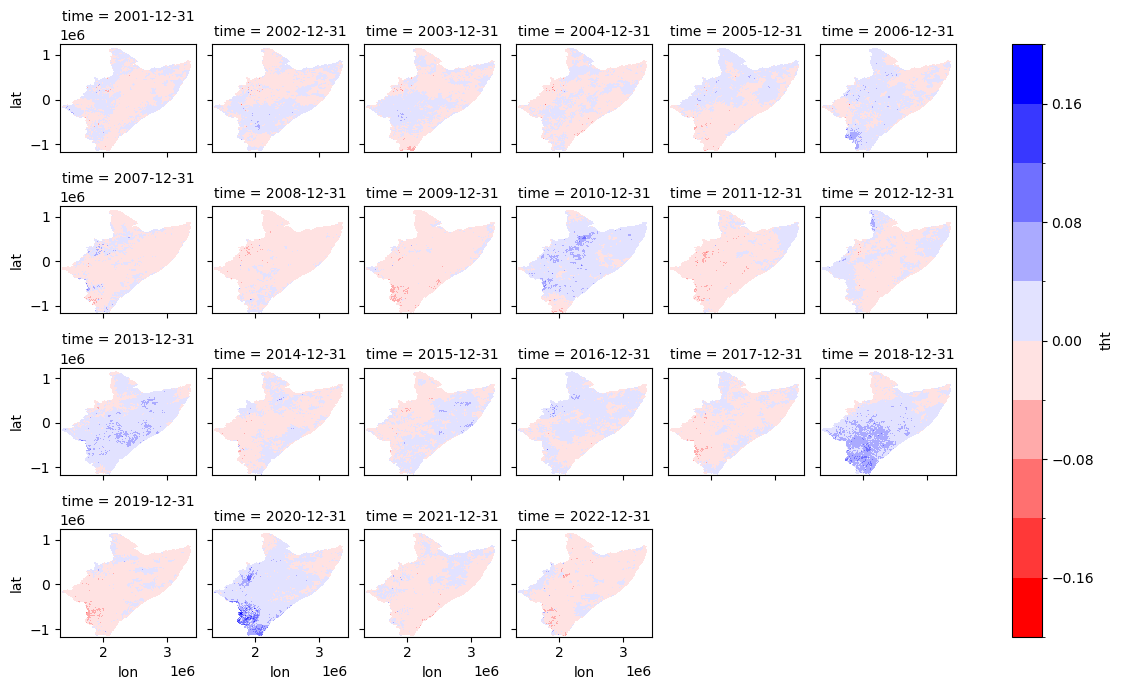

In [11]:
data = xr.open_dataset(fname_nc)['tht']
data.plot(x="lon", y="lat", col="time", robust=False, cmap='bwr_r', levels=11, figsize=(12, 7), vmin=-0.2, vmax=0.2, col_wrap=6)

In [16]:
fname_fig = "/home/aquichimbo/training/forecast/regional/postpp/fig/example.png"
plt.savefig(fname_fig, dpi=300)

<Figure size 640x480 with 0 Axes>

## 4. Forecasting Analysis

Calculate long term seasonal average for the selected variables of the historical simulation

In [10]:
dfseason = get_seasson_csv(fname_csv, [3, 4, 5], reset_index=False, aggregate=False)['pre_0']

/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()


In [11]:
# get month number
dfseason_mean = dfseason.groupby(dfseason.index.month).mean()
#dfseason.groupby(pd.TimeGrouper(freq='M')).mean()

In [12]:
dfseason_mean.index

Index([3, 4, 5], dtype='int32', name='Date')

* Get uncertainty of stochastic simulations

Create ensamble od stochastic simulations

In [13]:
# create an ensamble of model simulations
def create_ensamble(flist, field, agg_step='M', timefield='Date'):
    first_read = True
    for i, ifname in enumerate(flist):
        if first_read is True:
            df = aggregate_slice_csv(ifname, agg_step=agg_step, timefield=timefield)[[timefield, field]]
            # Rename the 'A' column to 'X'
            df.rename(columns={field: 'sim'+str(i)}, inplace=True)
            first_read = False
        else:
            df['sim'+str(i)] = aggregate_slice_csv(ifname, agg_step=agg_step, timefield=timefield)[field].values
    return df

def create_dataframe_stats(data):
    """This fuction create a dataframe with statistical values of
    q05, q33, q50, mean, q66, q95 from ensamble dataframe"""
    dfinterval = data[['Date']].copy()
    dfinterval['q5'] = data.quantile(q=0.05, axis=1, numeric_only=True).values
    dfinterval['q33'] = data.quantile(q=0.33, axis=1, numeric_only=True).values
    dfinterval['mean'] = data.mean(axis=1, numeric_only=True).values
    dfinterval['q50'] = data.quantile(q=0.50, axis=1, numeric_only=True).values
    dfinterval['q66'] = data.quantile(q=0.66, axis=1, numeric_only=True).values
    dfinterval['q95'] = data.quantile(q=0.95, axis=1, numeric_only=True).values
    dfinterval['Date'] = pd.to_datetime(dfinterval['Date'])
    dfinterval['month'] = np.array(dfinterval['Date'].dt.month, int)
    return dfinterval

In [14]:
#fname_list = [basin_path + "output/forecast/Tana_IMa_sto"+str(i)+"_avg.csv" for i in range(30)]
#fname_list = ["D:/HAD/postpp/csv/MAM_2022_realization_"+str(i)+"_avg.csv" for i in range(30)]
fname_list = ["/shared/training/forecast/regional/outputs/MAM_2022_realization_test_"+str(i)+"_avg.csv" for i in range(1,30)]

In [15]:
data = create_ensamble(fname_list, 'pre_0')
data

/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()
/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()
/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()
/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()
/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(nume

,Date,sim0,sim1,sim2,sim3,sim4,sim5,sim6,sim7,sim8,...,sim19,sim20,sim21,sim22,sim23,sim24,sim25,sim26,sim27,sim28
0,2022-03-31,53.355518,51.936824,36.456681,49.997749,27.982686,53.355518,51.936824,50.858848,23.573927,...,30.592740,32.159934,32.159934,51.780181,46.285535,51.936824,39.408169,23.615421,46.224174,23.573927
1,2022-04-30,93.501302,101.809235,89.453359,114.073488,96.719799,93.501302,101.809235,95.639110,93.402017,...,75.706013,70.259699,70.259699,87.245345,121.517597,101.809235,90.256752,94.722533,90.400389,93.402017
2,2022-05-31,81.468582,62.955899,70.121010,48.696139,68.913471,81.468582,62.955899,72.905591,58.542892,...,87.492903,86.508770,86.508770,72.757934,59.297001,62.955899,65.941157,78.093968,63.401270,58.542892


Calculate confidence interval

In [16]:
#q1, q2, q3 = gen.confidence_interval_TS(SMdata, weight, 0.95)
dfinterval = create_dataframe_stats(data)
dfinterval

,Date,q5,q33,mean,q50,q66,q95,month
0,2022-03-31,23.590524,36.070749,40.791789,39.408169,49.254780,54.237367,3
1,2022-04-30,72.438224,87.775269,92.198621,93.402017,96.157841,110.650738,4
2,2022-05-31,58.542892,63.645875,70.760086,68.913471,75.676142,87.099250,5


Create a figure representing the long term precipitaiton (LTA) for MAM and the forecasting.

In [17]:
#dfseason_mean.index.values
#dfseason_mean.values
#dfinterval['month']

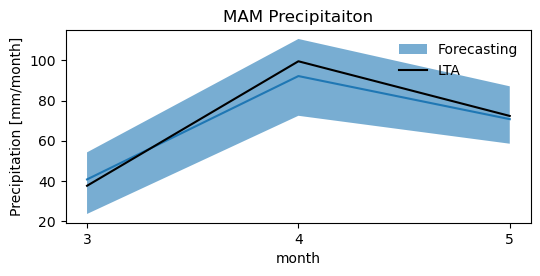

In [18]:

fig, ax = plt.subplots()#1, 1, sharex=True, sharey=True)
fig.set_size_inches(6, 2.5)
#plt.plot(dfinterval['month'].values, dfinterval['q50'].values)
plt.plot(dfinterval['month'].values, dfinterval['mean'].values)
plt.fill_between(dfinterval['month'], dfinterval['q5'], dfinterval['q95'], alpha=0.6, label='Forecasting')
plt.plot(dfseason_mean.index.values, dfseason_mean.values, 'k', label='LTA')
# ax.set_xticklabels([10,11,12])
plt.xlabel('month')
plt.ylabel('Precipitation [mm/month]')
plt.legend(frameon=False)
plt.title('MAM Precipitaiton')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

**TASK**: Plot uncertanties for soil moisture ("tht_0"), actual evapotranspiration ("aet_0"), and groundwater recharge ("rch_0")

1. Create ensamble data for the selected variable.
2. Calculate quantiles for the selected variable.
3. Plot results (copy script for plotting)

Soil Moisture

In [20]:
dfseason = get_seasson_csv(fname_csv, [3, 4, 5], reset_index=False, aggregate=False)['tht_0']
dfseason_mean = dfseason.groupby(dfseason.index.month).mean()

/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()


In [19]:
data = create_ensamble(fname_list, 'tht_0')
dfinterval = create_dataframe_stats(data)

/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()
/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()
/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()
/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()
/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(nume

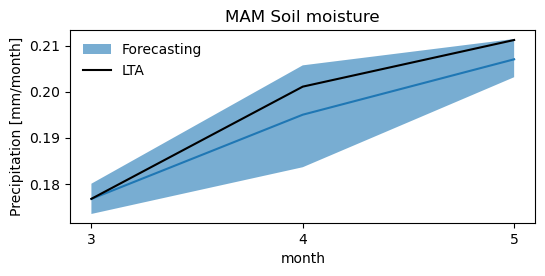

In [22]:
fig, ax = plt.subplots()#1, 1, sharex=True, sharey=True)
fig.set_size_inches(6, 2.5)
#plt.plot(dfinterval['month'].values, dfinterval['q50'].values)
plt.plot(dfinterval['month'].values, dfinterval['mean'].values)
plt.fill_between(dfinterval['month'], dfinterval['q5'], dfinterval['q95'], alpha=0.6, label='Forecasting')
plt.plot(dfseason_mean.index.values, dfseason_mean.values, 'k', label='LTA')
# ax.set_xticklabels([10,11,12])
plt.xlabel('month')
plt.ylabel('Precipitation [mm/month]')
plt.legend(frameon=False)
plt.title('MAM Soil moisture')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [23]:
dfseason = get_seasson_csv(fname_csv, [3, 4, 5], reset_index=False, aggregate=False)['aet_0']
dfseason_mean = dfseason.groupby(dfseason.index.month).mean()

/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()


In [24]:
data = create_ensamble(fname_list, 'aet_0')
dfinterval = create_dataframe_stats(data)

/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()
/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()
/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()
/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(numeric_only=True)#.reset_index()
/tmp/ipykernel_2182569/249471917.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(agg_step).sum(nume

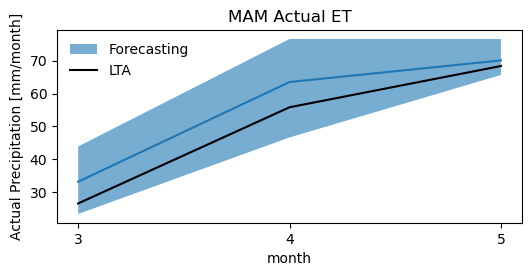

In [25]:
fig, ax = plt.subplots()#1, 1, sharex=True, sharey=True)
fig.set_size_inches(6, 2.5)
#plt.plot(dfinterval['month'].values, dfinterval['q50'].values)
plt.plot(dfinterval['month'].values, dfinterval['mean'].values)
plt.fill_between(dfinterval['month'], dfinterval['q5'], dfinterval['q95'], alpha=0.6, label='Forecasting')
plt.plot(dfseason_mean.index.values, dfseason_mean.values, 'k', label='LTA')
# ax.set_xticklabels([10,11,12])
plt.xlabel('month')
plt.ylabel('Actual Precipitation [mm/month]')
plt.legend(frameon=False)
plt.title('MAM Actual ET')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

### Visualizing deterministic and probabilistic forecast

In [33]:
import sys
#sys.path.append("C:/Users/Edisson/Documents/GitHub/CUWALID_training/Forecasting/scripts/src")
sys.path.append("/home/cuwalid/CUWALID/CUWALID_training/Forecasting/scripts")
#sys.path.append("/home/aquichimbo/CUWALID/CUWALID_training/Forecasting/scripts/src/")

import CUWALID_forecast_tools as cuwalid
import CUWALID_view_tool as cuwalidplt
import xarray as xr

In [34]:
#path = "C:/Users/Edisson/OneDrive - Cardiff University/PhD/WS/LandLab/HAD/WS/"
path = "/home/cuwalid/training/historical/regional/model/input/"

path_mask = path + "HAD_mask_utm_m.asc"
path_river =  path + "HAD_riv_length_utm.asc"
#shapefile_county = "D:/HAD/data/gis/Horn_Africa/Horn_africa_contry.shp"
#shapefile_county = "/home/cuwalid/Datasets/data/shp/wgs84/Horn_africa_contry.shp"
shapefile_county = "/home/cuwalid/Datasets/data/shp/utm/HAD_country_bnd_utm.shp"

* Deterministic forecast

In [35]:
#fname = "D:/HAD/postpp/netcdf/MAM_2022_realization_pre_MAM_2022_deterministic_forecast.nc"
#fname = "/home/cuwalid/training/forecast/regional/postpp/netcdf/MAM_2022_realization_pet_MAM_2022_deterministic_forecast.nc"

In [36]:
#fname = "D:/HAD/postpp/netcdf/MAM_2022_realization_pre_MAM_2022_deterministic_forecast.nc"
#fname = "/home/cuwalid/training/forecast/regional/postpp/netcdf/MAM_2022_realization_test_pet_MAM_2022_deterministic_forecast.nc"
#fname = "/home/<username>/training/forecast/regional/postpp/netcdf/MAM_2022_realization_test_pet_MAM_2022_deterministic_forecast.nc"
fname = "/home/aquichimbo/training/forecast/regional/postpp/netcdf/MAM_2022_realization_test_pre_MAM_2022_deterministic_forecast.nc"
#fname = "/home/cuwalid/training/forecast/regional/postpp/netcdf/MAM_2022_realization_test_pet_MAM_2022_probabilistic_tercile_forecast.nc"

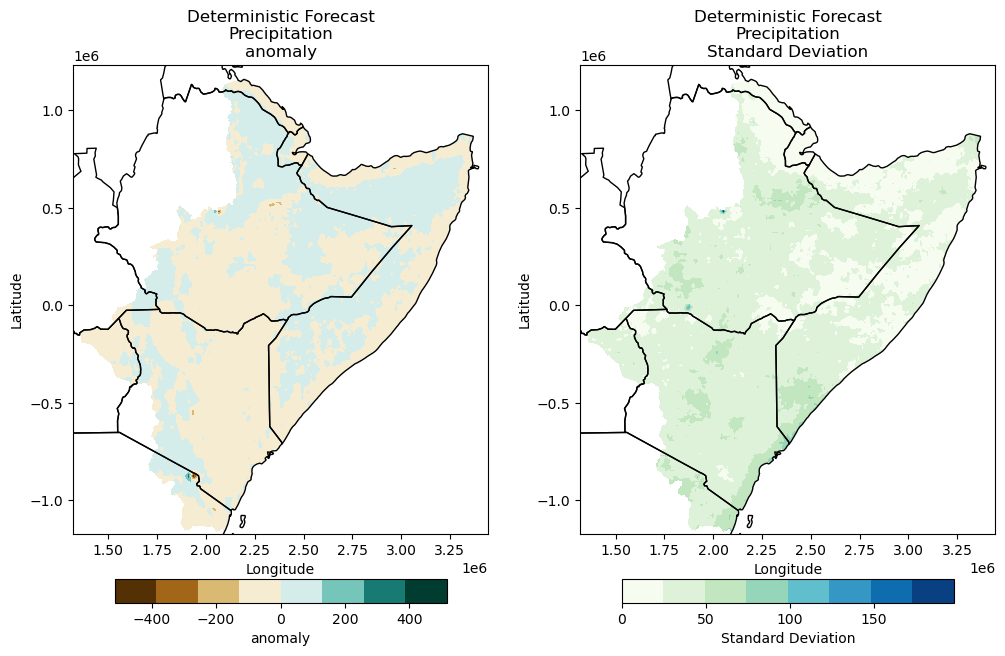

In [37]:
data = xr.open_dataset(fname)
im = cuwalidplt.plot_deterministic_forecast(data,
			title="Deterministic Forecast\nPrecipitation",
			reproject=False,
			fshapefile=shapefile_county,
			plot_anomaly=True,
			fmask=path_mask
            )

**TASK**: Plot probabilistic forecasting of soil moisture ("tht_0"), actual evapotranspiration ("aet_0"), and groundwater recharge ("rch_0")

1. Check if the ensamble has been created for the selected variable
2. Check if long term average values for the selected variable have been estimated.
3. Plot results (copy script for plotting)

* Probabilistic forecast

In [30]:
#fname = "D:/HAD/postpp/netcdf/MAM_2022_realization_pre_MAM_2022_probabilistic_tercile_forecast.nc"
#fname = "/home/cuwalid/training/forecast/regional/postpp/netcdf/MAM_2022_realization_pet_MAM_2022_probabilistic_tercile_forecast.nc"
#fname = "/home/cuwalid/training/forecast/regional/postpp/netcdf/MAM_2022_realization_test_aet_MAM_2022_probabilistic_tercile_forecast.nc"
#fname = "/home/<username>/training/forecast/regional/postpp/netcdf/MAM_2022_realization_test_aet_MAM_2022_probabilistic_tercile_forecast.nc"
fname = "/home/aquichimbo/training/forecast/regional/postpp/netcdf/MAM_2022_realization_test_pre_MAM_2022_probabilistic_tercile_forecast.nc"

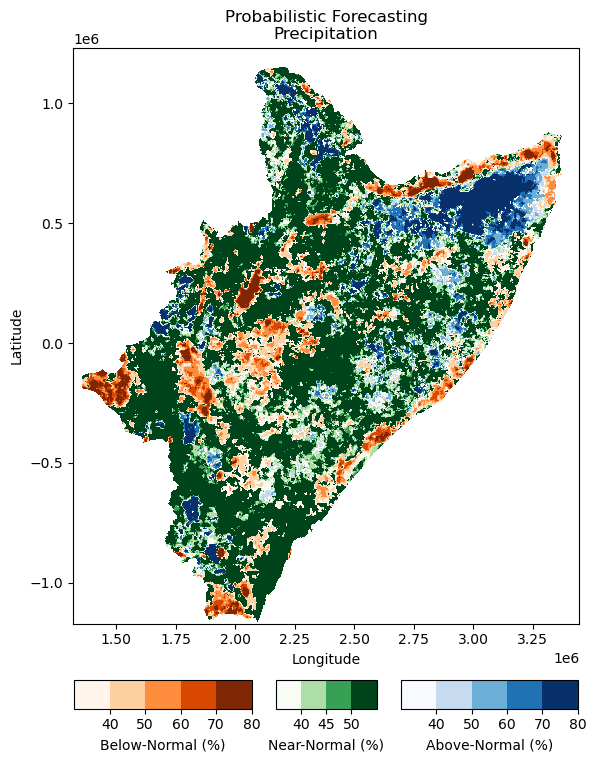

In [31]:
data = xr.open_dataset(fname)
im = cuwalidplt.plot_probabilistic_tercile_forecast(data,
			title="Probabilistic Forecasting\nPrecipitation",
			reproject=False,
			fshapefile=shapefile_county,
			fmask=path_mask
            )

**TASK**: Plot probabilistic forecasting of soil moisture ("tht_0"), actual evapotranspiration ("aet_0"), and groundwater recharge ("rch_0")

1. Check if the ensamble has been created for the selected variable
2. Check if quantiles of the selected variable have been estimated.
3. Plot results (copy script for plotting)

In [73]:
#fname = "/home/cuwalid/training/historical/regional/postpp/netcdf/HAD_IMERGba_sim0_MAM_mean.nc"

In [74]:
#data = xr.open_dataset(fname)

In [75]:
#data["pre"].plot(x="lon", y="lat", robust=False, cmap='gist_ncar_r', vmin=200, vmax=1600, levels=15)